In [1]:
!pip install -r requirements.txt


Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/transformers-4.47.0+computecanada-py3-none-any.whl (from -r requirements.txt (line 2))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/nltk-3.9.1+computecanada-py3-none-any.whl (from -r requirements.txt (line 5))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/matplotlib-3.9.2+computecanada-cp312-cp312-linux_x86_64.whl (from -r requirements.txt (line 6))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic/huggingface_hub-0.26.5+computecanada-py3-none-any.whl (from transformers->-r requirements.txt (line 2))
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic/tokenizers-0.21.

In [1]:
!pip uninstall torch -y


Found existing installation: torch 2.5.1+computecanada
Uninstalling torch-2.5.1+computecanada:
  Successfully uninstalled torch-2.5.1+computecanada


In [ ]:
!pip install torch

Looking in links: /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/generic, /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/generic
Processing /cvmfs/soft.computecanada.ca/custom/python/wheelhouse/gentoo2023/x86-64-v3/torch-2.5.1+computecanada-cp312-cp312-linux_x86_64.whl


In [2]:
import re
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import RobertaTokenizer, RobertaModel
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import pandas as pd
import nltk
import random
import numpy as np
from nltk.corpus import stopwords
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

/home/rumman28/rumman-jupyter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
!pwd


/project/6006134/rumman28/csci6100G


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rumman28/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Epoch [1/10], Loss: 0.6847
Epoch [2/10], Loss: 0.5975
Epoch [3/10], Loss: 0.5033
Epoch [4/10], Loss: 0.3735
Epoch [5/10], Loss: 0.2524
Epoch [6/10], Loss: 0.1601
Epoch [7/10], Loss: 0.1164
Epoch [8/10], Loss: 0.0641
Epoch [9/10], Loss: 0.0660
Epoch [10/10], Loss: 0.0547


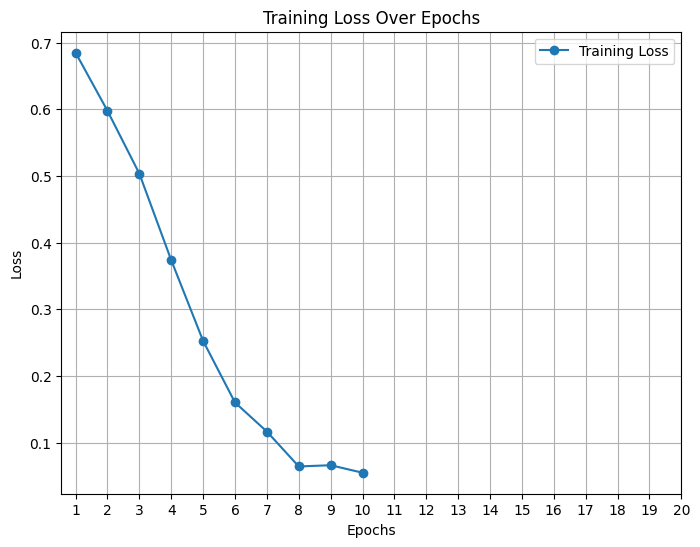

Test Accuracy: 0.7755
Precision: 0.7608
Recall: 0.7755
F1-Score: 0.7657


In [7]:


# Download NLTK stopwords if not already available
nltk.download('stopwords')

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Load the dataset
file_path = 'Dataset/mozilla_bug_report_data.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df = bug_report_df.fillna("")

# Preprocess the 'Description' column
bug_report_df['processed_description'] = bug_report_df['Description'].apply(preprocess_text)

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))

# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(
    descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Custom Dataset class to load bug report data
class BugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function to handle variable-length sequences
def collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['labels'] for item in batch]

    # Pad the sequences within the batch
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)

    labels = torch.stack(labels)  # Stack labels into a tensor

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'labels': labels
    }

# CNN Classifier Model
class BugReportClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(BugReportClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, kernel_size=(3, embedding_dim))  # CNN layer
        self.pool = nn.MaxPool2d(kernel_size=(2, 1))
        self.fc = nn.Linear(100, num_classes)  # Fully connected layer

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension for CNN (batch_size, 1, seq_length, embedding_dim)
        x = self.pool(nn.functional.relu(self.conv1(x)))  # Convolution + Activation + Pooling
        x = torch.mean(x, dim=2)  # Reduce sequence length dimension by averaging
        x = x.view(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = self.fc(x)  # Final classification layer
        return x

# Create train and test datasets and dataloaders
train_dataset = BugReportDataset(train_descriptions, train_labels, tokenizer)
test_dataset = BugReportDataset(test_descriptions, test_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Model setup
embedding_dim = 768  # Embedding size of CodeBERT
cnn_model = BugReportClassifier(embedding_dim, num_classes).to(device)

# Include both CNN and CodeBERT in the optimizer
optimizer = optim.Adam(
    list(model.parameters()) + list(cnn_model.parameters()),
    lr=2e-5  # Lower learning rate for fine-tuning
)
criterion = nn.CrossEntropyLoss()

# Training loop
loss_values = []
for epoch in range(10):  # Number of epochs
    cnn_model.train()
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        inputs = batch['input_ids'].to(device)
        attention_masks = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through CodeBERT to get embeddings
        outputs = model(input_ids=inputs, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state

        # Forward pass through CNN classifier
        cnn_outputs = cnn_model(embeddings)

        # Compute loss and backpropagate
        loss = criterion(cnn_outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    loss_values.append(epoch_loss)
    print(f"Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}")

# Plot the training loss graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), loss_values, marker='o', label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(1, 21))
plt.legend()
plt.grid(True)
plt.show()

# Function to evaluate the model on the test set
def evaluate_model(codebert_model, cnn_model, data_loader):
    cnn_model.eval()
    codebert_model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch['input_ids'].to(device)
            attention_masks = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass through CodeBERT to get embeddings
            outputs = codebert_model(input_ids=inputs, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state

            # Forward pass through CNN classifier
            cnn_outputs = cnn_model(embeddings)

            # Get the predicted class (highest probability)
            preds = torch.argmax(cnn_outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(model, cnn_model, test_loader)

# Calculate accuracy
accuracy = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {accuracy:.4f}")

# Calculate precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


In [ ]:
##Contrastive learning

Contrastive Epoch [1/20], Loss: 1.4321
Contrastive Epoch [2/20], Loss: 1.2638
Contrastive Epoch [3/20], Loss: 1.0244
Contrastive Epoch [4/20], Loss: 0.8570
Contrastive Epoch [5/20], Loss: 0.7831
Contrastive Epoch [6/20], Loss: 0.7336
Contrastive Epoch [7/20], Loss: 0.7125
Contrastive Epoch [8/20], Loss: 0.6831
Contrastive Epoch [9/20], Loss: 0.6639
Contrastive Epoch [10/20], Loss: 0.6411


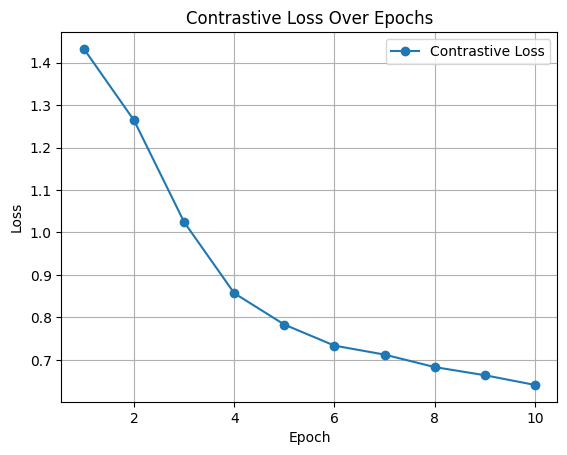

Classification Epoch [1/20], Loss: 0.3635
Classification Epoch [2/20], Loss: 0.2639
Classification Epoch [3/20], Loss: 0.2105
Classification Epoch [4/20], Loss: 0.1570
Classification Epoch [5/20], Loss: 0.1151
Classification Epoch [6/20], Loss: 0.0998
Classification Epoch [7/20], Loss: 0.0794
Classification Epoch [8/20], Loss: 0.0691
Classification Epoch [9/20], Loss: 0.0553
Classification Epoch [10/20], Loss: 0.0520


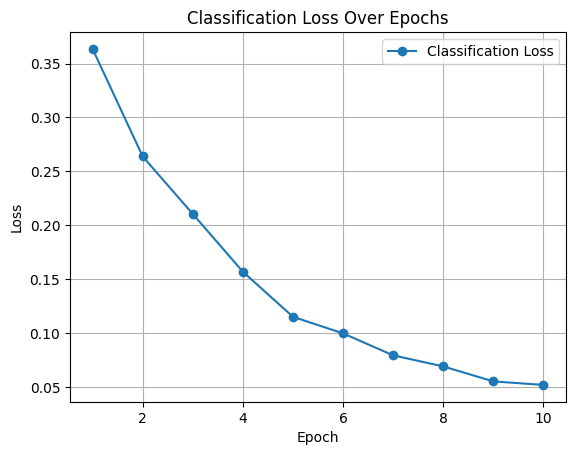

Test Accuracy: 0.7900
Precision: 0.7618
Recall: 0.7900
F1-Score: 0.7687


In [9]:

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)

# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
set_seed(42)

# Load the dataset
file_path = 'Dataset/mozilla_bug_report_data.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df['processed_description'] = bug_report_df['Description'].fillna("")

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))


# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn, worker_init_fn=seed_worker
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(10):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(10):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Contrastive Epoch [1/20], Loss: 1.4269
Contrastive Epoch [2/20], Loss: 1.2650
Contrastive Epoch [3/20], Loss: 1.0288
Contrastive Epoch [4/20], Loss: 0.8517
Contrastive Epoch [5/20], Loss: 0.7751
Contrastive Epoch [6/20], Loss: 0.7358
Contrastive Epoch [7/20], Loss: 0.7092
Contrastive Epoch [8/20], Loss: 0.6899
Contrastive Epoch [9/20], Loss: 0.6562
Contrastive Epoch [10/20], Loss: 0.6376
Contrastive Epoch [11/20], Loss: 0.6252
Contrastive Epoch [12/20], Loss: 0.6144
Contrastive Epoch [13/20], Loss: 0.5971
Contrastive Epoch [14/20], Loss: 0.5892
Contrastive Epoch [15/20], Loss: 0.5808
Contrastive Epoch [16/20], Loss: 0.5714
Contrastive Epoch [17/20], Loss: 0.5589
Contrastive Epoch [18/20], Loss: 0.5462
Contrastive Epoch [19/20], Loss: 0.5482
Contrastive Epoch [20/20], Loss: 0.5307


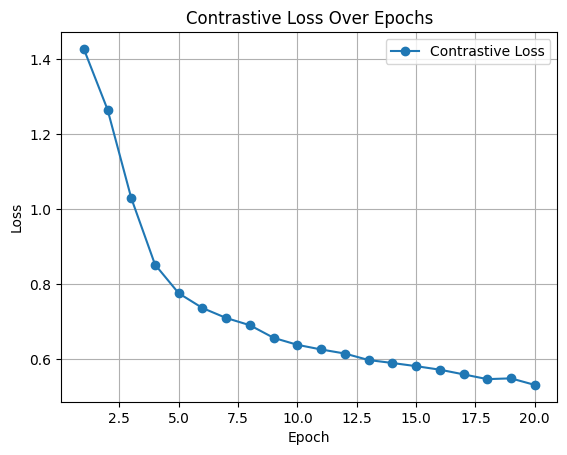

Classification Epoch [1/10], Loss: 0.3436
Classification Epoch [2/10], Loss: 0.2585
Classification Epoch [3/10], Loss: 0.2043
Classification Epoch [4/10], Loss: 0.1573
Classification Epoch [5/10], Loss: 0.1210
Classification Epoch [6/10], Loss: 0.0864
Classification Epoch [7/10], Loss: 0.0646
Classification Epoch [8/10], Loss: 0.0442
Classification Epoch [9/10], Loss: 0.0479
Classification Epoch [10/10], Loss: 0.0426


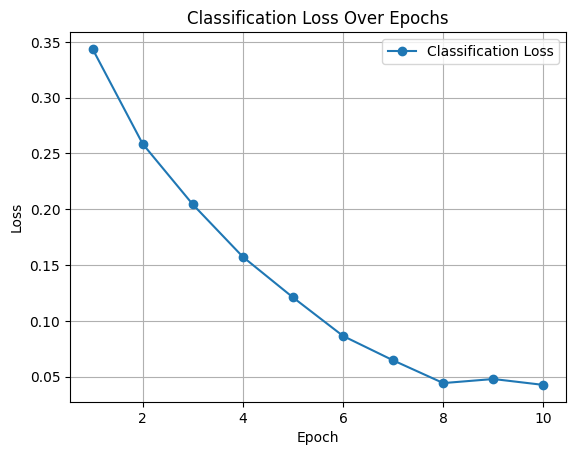

Test Accuracy: 0.8065
Precision: 0.7606
Recall: 0.8065
F1-Score: 0.7743


In [4]:

# Preprocess function to clean and tokenize the text
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    words = text.split()
    return ' '.join(words)
# Set the seed for reproducibility
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Set the seed
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


# Set the seed
set_seed(42)

# Load the dataset
file_path = 'Dataset/mozilla_bug_report_data.csv'
bug_report_df = pd.read_csv(file_path)
bug_report_df['processed_description'] = bug_report_df['Description'].fillna("")

# Revert to original severity labels
labels = bug_report_df['Severity'].tolist()

# Ensure labels are integers
labels = [int(label) for label in labels]

# Correct label remapping (map 2 to 0, 3 to 1, 4 to 2, 5 to 3)
label_mapping = {1: 0, 2: 1, 4: 2, 5: 3, 6: 4}
labels = [label_mapping[label] for label in labels]

# Number of classes
num_classes = len(set(labels))


# Split the data into train and test sets
descriptions = bug_report_df['processed_description'].tolist()
train_descriptions, test_descriptions, train_labels, test_labels = train_test_split(descriptions, labels, test_size=0.2, random_state=42
)

# Load CodeBERT tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("microsoft/codebert-base")
model = RobertaModel.from_pretrained("microsoft/codebert-base")

# Dataset Class for Contrastive Learning
class ContrastiveBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer
        self.pairs = self.create_pairs()

    def create_pairs(self):
        pairs = []
        severity_groups = {label: [] for label in set(self.labels)}

        for idx, label in enumerate(self.labels):
            severity_groups[label].append(self.descriptions[idx])

        for label, group in severity_groups.items():
            for i in range(len(group) - 1):
                # Positive pair
                pairs.append((group[i], group[i + 1], 1))
                # Negative pair
                neg_label = random.choice([l for l in severity_groups if l != label])
                neg_sample = random.choice(severity_groups[neg_label])
                pairs.append((group[i], neg_sample, 0))

        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        desc1, desc2, label = self.pairs[idx]
        inputs1 = self.tokenizer(desc1, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs2 = self.tokenizer(desc2, return_tensors="pt", truncation=True, padding=True, max_length=256)
        return {
            'input_ids_1': inputs1['input_ids'].squeeze(0),
            'attention_mask_1': inputs1['attention_mask'].squeeze(0),
            'input_ids_2': inputs2['input_ids'].squeeze(0),
            'attention_mask_2': inputs2['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }

# Dataset for Classification
class ClassificationBugReportDataset(Dataset):
    def __init__(self, descriptions, labels, tokenizer):
        self.descriptions = descriptions
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        description = self.descriptions[idx]
        label = self.labels[idx]
        inputs = self.tokenizer(description, return_tensors="pt", truncation=True, padding=True, max_length=256)
        inputs['label'] = torch.tensor(label, dtype=torch.long)
        return inputs

# Custom collate function for contrastive learning
def contrastive_collate_fn(batch):
    input_ids_1 = [item['input_ids_1'] for item in batch]
    attention_mask_1 = [item['attention_mask_1'] for item in batch]
    input_ids_2 = [item['input_ids_2'] for item in batch]
    attention_mask_2 = [item['attention_mask_2'] for item in batch]
    labels = [item['label'] for item in batch]

    # Pad the sequences to the same length
    input_ids_1_padded = pad_sequence(input_ids_1, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_1_padded = pad_sequence(attention_mask_1, batch_first=True, padding_value=0)
    input_ids_2_padded = pad_sequence(input_ids_2, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask_2_padded = pad_sequence(attention_mask_2, batch_first=True, padding_value=0)

    labels_tensor = torch.tensor(labels, dtype=torch.float)

    return {
        'input_ids_1': input_ids_1_padded,
        'attention_mask_1': attention_mask_1_padded,
        'input_ids_2': input_ids_2_padded,
        'attention_mask_2': attention_mask_2_padded,
        'label': labels_tensor
    }

# Custom collate function for classification
def classification_collate_fn(batch):
    input_ids = [item['input_ids'].squeeze(0) for item in batch]
    attention_masks = [item['attention_mask'].squeeze(0) for item in batch]
    labels = [item['label'] for item in batch]

    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_masks_padded = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    return {
        'input_ids': input_ids_padded,
        'attention_mask': attention_masks_padded,
        'label': labels_tensor
    }

# Contrastive Loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.cosine_similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, embedding_1, embedding_2, label):
        cos_sim = self.cosine_similarity(embedding_1, embedding_2) / self.temperature
        pos_loss = -torch.log(cos_sim[label == 1].sigmoid() + 1e-9).mean() if (label == 1).any() else 0
        neg_loss = -torch.log((1 - cos_sim[label == 0].sigmoid()) + 1e-9).mean() if (label == 0).any() else 0
        return pos_loss + neg_loss

# Fine-tuning CodeBERT with Contrastive Learning
train_contrastive_dataset = ContrastiveBugReportDataset(train_descriptions, train_labels, tokenizer)
train_contrastive_loader = DataLoader(
    train_contrastive_dataset, batch_size=16, shuffle=True, collate_fn=contrastive_collate_fn, worker_init_fn=seed_worker
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

contrastive_loss_fn = NTXentLoss(temperature=0.5)
contrastive_optimizer = optim.Adam(model.parameters(), lr=2e-5)

contrastive_loss_values = []
for epoch in range(20):
    model.train()
    running_loss = 0.0

    for batch in train_contrastive_loader:
        input_ids_1 = batch['input_ids_1'].to(device)
        attention_mask_1 = batch['attention_mask_1'].to(device)
        input_ids_2 = batch['input_ids_2'].to(device)
        attention_mask_2 = batch['attention_mask_2'].to(device)
        labels = batch['label'].to(device)

        contrastive_optimizer.zero_grad()
        outputs_1 = model(input_ids=input_ids_1, attention_mask=attention_mask_1).last_hidden_state[:, 0, :]
        outputs_2 = model(input_ids=input_ids_2, attention_mask=attention_mask_2).last_hidden_state[:, 0, :]

        loss = contrastive_loss_fn(outputs_1, outputs_2, labels)
        loss.backward()
        contrastive_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_contrastive_loader)
    contrastive_loss_values.append(epoch_loss)
    print(f"Contrastive Epoch [{epoch+1}/20], Loss: {epoch_loss:.4f}")

# Plot the contrastive loss
plt.plot(range(1, len(contrastive_loss_values) + 1), contrastive_loss_values, marker='o', label='Contrastive Loss')
plt.title('Contrastive Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Define classification datasets
train_classification_dataset = ClassificationBugReportDataset(train_descriptions, train_labels, tokenizer)
test_classification_dataset = ClassificationBugReportDataset(test_descriptions, test_labels, tokenizer)

# Classification DataLoaders
train_classification_loader = DataLoader(
    train_classification_dataset, batch_size=16, shuffle=True, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)
test_classification_loader = DataLoader(
    test_classification_dataset, batch_size=16, shuffle=False, collate_fn=classification_collate_fn, worker_init_fn=seed_worker
)

# Add a classification head to the model
class CodeBERTWithClassifier(nn.Module):
    def __init__(self, model, num_classes):
        super(CodeBERTWithClassifier, self).__init__()
        self.codebert = model
        self.classification_head = nn.Linear(model.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        output = self.codebert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = output.last_hidden_state[:, 0, :]  # Use CLS token representation
        logits = self.classification_head(pooled_output)
        return logits

# Initialize the classification model
classification_model = CodeBERTWithClassifier(model, num_classes).to(device)

# Define optimizer and loss function for classification
classification_optimizer = optim.Adam(classification_model.parameters(), lr=2e-5)
classification_criterion = nn.CrossEntropyLoss()

# Fine-tune for classification
classification_loss_values = []
for epoch in range(10):
    classification_model.train()
    running_loss = 0.0

    for batch in train_classification_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        classification_optimizer.zero_grad()
        logits = classification_model(input_ids, attention_mask)
        loss = classification_criterion(logits, labels)
        loss.backward()
        classification_optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_classification_loader)
    classification_loss_values.append(epoch_loss)
    print(f"Classification Epoch [{epoch+1}/10], Loss: {epoch_loss:.4f}")

# Plot the classification loss
plt.plot(range(1, len(classification_loss_values) + 1), classification_loss_values, marker='o', label='Classification Loss')
plt.title('Classification Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Evaluation function
def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids, attention_mask)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

# Evaluate the model on the test set
test_preds, test_labels = evaluate_model(classification_model, test_classification_loader)

# Calculate metrics
test_accuracy = accuracy_score(test_labels, test_preds)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")